<a href="https://colab.research.google.com/github/ashishballa/ashishballa/blob/main/Module_5_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 5 Lab

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the Boston Housing dataset
df = spark.read.csv("/content/drive/MyDrive/datasets/BostonHousing.csv", header=True, inferSchema=True)

df.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [7]:
from pyspark.ml.feature import VectorAssembler

# Define the feature columns (all columns except the target 'medv')
feature_columns = [col for col in df.columns if col != 'medv']

# Assemble feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df)


In [8]:
from pyspark.ml.feature import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Fit and transform the data
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)


In [9]:
from pyspark.ml.feature import PCA

# Initialize PCA and set the input and output column names
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')

# Fit the PCA model
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)


In [10]:
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = df_pca.select("pca_features").toPandas()


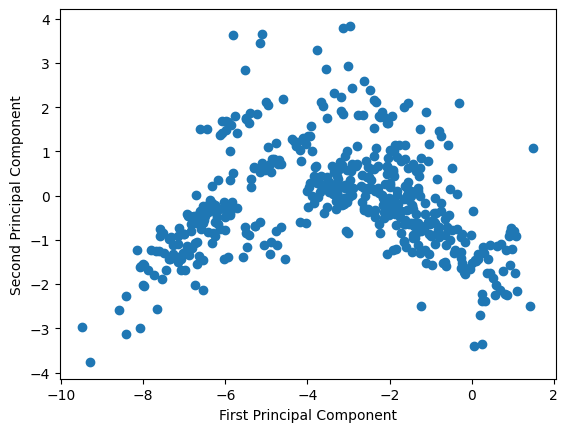

In [11]:
import matplotlib.pyplot as plt

# Scatter plot for the two principal components
plt.scatter(pandas_df['pca_features'].apply(lambda x: x[0]), pandas_df['pca_features'].apply(lambda x: x[1]))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


In [12]:
# Split the data into 80% training and 20% testing
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)


In [13]:
from pyspark.ml.regression import LinearRegression

# Initialize Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='medv')

# Fit the model to training data
lr_model = lr.fit(train_data)


In [14]:
# Display the coefficients and intercept for linear regression
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [-0.1136220372940893,0.04890918693405423,0.02379542898673218,2.8017719987351315,-18.41542454118947,3.5158797633119243,0.005211682161471423,-1.416383072353979,0.33176693159370374,-0.013607893704163855,-0.9534143338408103,0.008602677392853194,-0.5195035312476691]
Intercept: 38.61699144573505


In [15]:
# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print("Root Mean Squared Error:", test_results.rootMeanSquaredError)


Root Mean Squared Error: 4.671806485171292


#Residual Analysis

In [16]:
# Get predictions on test data
predictions = lr_model.transform(test_data)


In [17]:
from pyspark.sql.functions import col

# Compute residuals
predictions_with_residuals = predictions.withColumn('residual', col('medv') - col('prediction'))


In [18]:
import pandas as pd

# Convert to Pandas DataFrame
pandas_df_residuals = predictions_with_residuals.select('residual').toPandas()


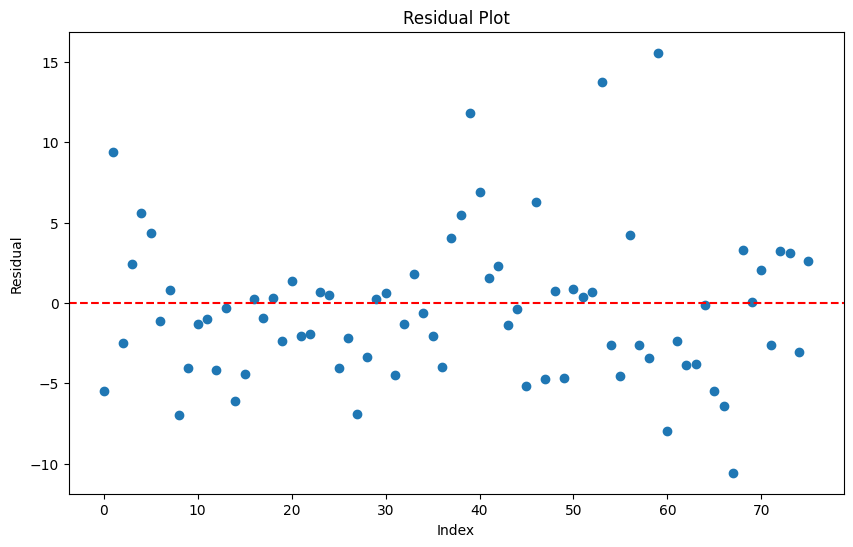

In [19]:
import matplotlib.pyplot as plt

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pandas_df_residuals)), pandas_df_residuals['residual'])
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()


#K-fold

In [20]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='medv')

# Define a grid of hyperparameters to search over
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()

# Define the cross-validation
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol='medv'),
    numFolds=5  # Number of folds
)

# Fit the model
cv_model = crossval.fit(df_assembled)

# Collect the results and show them
cv_results = cv_model.transform(df_assembled)


In [21]:
# Get the average RMSE
avg_rmse = min(cv_model.avgMetrics)

print(f"Average RMSE across all folds: {avg_rmse}")


Average RMSE across all folds: 4.770018877262881
